# Задача 1 
Посчитать численно $DV01$ как разностную производную.
1. Номер выпуска облигации определяет функция getBond ниже
1. Процентные ставки известны ниже curve_tenors, curve_rates
1. Использоватье линейную интерполяцию кубическими сплайнами (см. пример ниже)


Данные о выпуске облигаций доступны по ссылке 
https://www.efd.admin.ch/efd/en/home/the-fdf/nsb-news_list.msg-id-85031.html

$$ PV  = PV (r_1, r_2, r_3, ..., r_N) = \sum \limits_{i=1}^{N} \frac{C_i}{(1 + r_i)^{t_i}} $$
где 
* $r_i$ - значение ставки

* $C_i$ - выплата в день купонного платежа под номером $i$

$$ DV01 (r_1, r_2,  ..., r_N) = \lim \limits_{\delta \to 0} \frac{PV (r_1 + \delta r, r_2 + \delta r, ..., r_N + \delta r) - PV (r_1, r_2,  ..., r_N)}{\delta}  \approx
\frac{PV (r_1 + \Delta r, r_2 + \Delta r, ..., r_N + \Delta r) - PV (r_1 - \Delta r, r_2 - \Delta r, ..., r_N - \Delta r)}{2 \Delta r}$$

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize
import scipy.interpolate
import pandas as pd


In [54]:
sns.set(style="darkgrid")

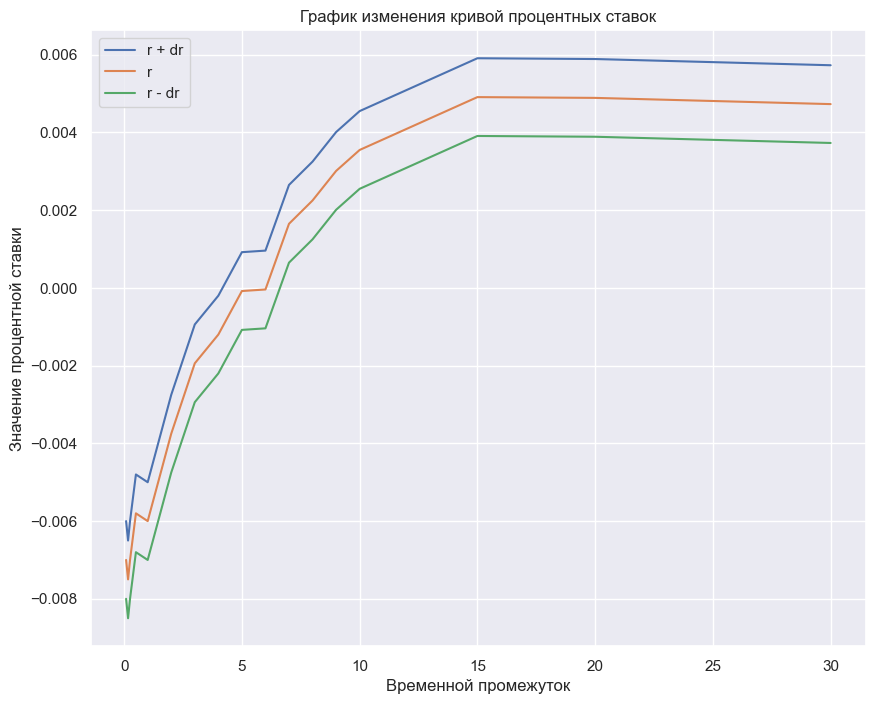

In [55]:
curve_tenors = np.array([1/12, 1/6, 0.25, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0, 30.0])
curve_rates = np.array([-0.700, -0.750, -0.700, -0.580, -0.600, -0.375, -0.194, -0.120, -0.008, -0.004, 0.165, 0.225, 0.301, 0.355, 0.491, 0.489, 0.473])*1e-2

plt.figure(figsize=(10, 8))
plt.plot(curve_tenors, curve_rates + 1e-3, label = 'r + dr')
plt.plot(curve_tenors, curve_rates, label = 'r')
plt.plot(curve_tenors, curve_rates - 1e-3, label = 'r - dr')
plt.xlabel("Временной промежуток")
plt.ylabel("Значение процентной ставки")
plt.title("График изменения кривой процентных ставок")
plt.legend();

In [8]:
def getBond(email):
    import hashlib
    h = int(hashlib.sha1(email.encode('utf-8')).hexdigest(), 16)
    bonds = ['CH0184249990', 'CH0344958688', 'CH0344958498']
    return bonds[h % len(bonds)]
getBond('makxim.kiryakin@gmail.com')

'CH0344958688'

**Bond information:**
|                         |                                             |
|-------------------------|---------------------------------------------|
| Interest rate           | 0.50%                                       |
| Maturity                | 27.06.2032                                  |
| Amount                  | CHF 283.500 million  (0 million own tranche)|
| Issue price             | 107.50%                                     |
| Yield p.a.              | -0.189%                                     |
| Total bids              | CHF 396.500 million                         |
| Allotment in last price | 100%                                        |
| category                |                                             |
| Offers without price    | CHF 74.500 million                          |
| details                 |                                             |
| Settlement              | 22.09.2021                                  |
| ISIN no. (until         | CH0557778377                                |
| settlement)             |                                             |
| Fungible with ISIN no.  | CH0344958688                                |

In [86]:
(pd.to_datetime('2022.06.27') - pd.to_datetime('2021.09.22')).days

278

In [57]:
days = np.array([278, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360]) 
payments = np.array([5 * 278/360, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1005])

Price = 1000*1.075

def pv_ytm(days, payments, ytm):
    days = np.cumsum(days) / 360
    df = np.power(1.0 / (ytm + 1.0), days)
    return np.sum(payments*df)

ytm = scipy.optimize.broyden1( lambda x: (pv_ytm(days, payments, x) - Price)**2, 0.0)
ytm, pv_ytm(days, payments, ytm)


(array(-0.00188526), 1074.998393665183)

`Дюрация Маколея (Maccaulay duration)` -
это средневзвешенный срок погашения облигации.

 Она
показывает среднее время, за которое мы полностью вернем
свои вложения в долговую бумагу

$$D = \frac{\sum_{i=1}^{m}\frac{CF_i}{(1 + r)^{t_i}}  t_i}{P}$$

* `D` - рассчитываемая величина дюрации

* `P` - рыночная цена облигации

* `CF` - платеж

* `r` - ставка дисконтирования

* `t` - момент времени i-ого платежа

In [ ]:
def duration(days, payments, ytm, price):
    """
    :param days      массив дней, в которые присходит выплата по бумаге
    :param payment   величина выплаты
    :param ytm       доходность к погашению
    :param price     текущая цена на рынке
    :return          значени дюрации Маколея
    """
    days = np.cumsum(days) / 360
    df = np.power(1.0 / (ytm + 1.0), days)
    return np.sum(payments*df*days) / price

In [60]:
duration(days, payments, ytm, Price)

10.378125634967398

`Модифицированная дюрация` -
показатель процентного риска долговой ценной бумаги.

Показывает на сколько изменится цена облигации при
изменении процентных ставок на 1%.

$$Модифицированная \space дюрация = \frac{D}{(1 + \frac{YTM}{n})}$$

* `D` - дюрация Маколея

* `YTM` - доходность к погашению 

* `n` - количество купонных выплат в год

In [58]:
def mod_duration(days, payments, ytm, price, n):
    """
    :param days      массив дней, в которые присходит выплата по бумаге
    :param payment   величина выплаты
    :param ytm       доходность к погашению
    :param price     текущая цена на рынке
    :param n         число выплат в год
    :return          значени модифицированной дюрации Маколея
    """
    days = np.cumsum(days) / 360
    df = np.power(1.0 / (ytm + 1.0), days)
    return np.sum(payments*df*days) / price / (1 + ytm/n)

In [62]:
mod_duration(days, payments, ytm, Price, 2)

10.53510241155662

`Dollar value of one basis point`
или `DV01` - мера риска, показывающая прибыль или убыток от владения
облигацией, если доходность изменится на 1 базисный
пункт $=0.01%$.

$$DV01 = \frac{Модифицированная \space дюрация * P}{10000}$$

In [65]:
DV01 = mod_duration(days, payments, ytm, Price, 2) * Price * 1e-4
DV01

1.1325235092423367

## Рассчёт dv01 как раздностной производной:

$$\frac{dPV}{dr} \approx \frac{PV(r + \delta r ) - PV(r -  \delta r )}{2 \delta r }$$

In [73]:
dv01_num = (pv_ytm(days, payments, ytm-1e-4) - pv_ytm(days, payments, ytm+1e-4))*0.5 
dv01_num

1.1335933569044983

In [74]:
f = scipy.interpolate.interp1d(curve_tenors, curve_rates - 1e-3, kind = 'cubic')
f1 = scipy.interpolate.interp1d(curve_tenors, curve_rates + 1e-3, kind = 'cubic')

## Рассчет $PV$ по ставкам из условия

In [75]:
days = np.array([278, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360]) 
payments = np.array([5 * 278/360, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1005])

Price = 1000*1.075

def pv_rates(days, payments, f):
    days = np.cumsum(days) / 360
    df = np.power(1.0 / (f(days) + 1.0), days)
    return np.sum(payments*df)

pv_rates(days, payments, f)

1023.4011996111798

In [78]:
dv01_num = 0.5*(pv_rates(days, payments, f) - pv_rates(days, payments, f1))
dv01_num

10.605656419427362

# Задача 2

1. Взяв облигацию из предыдущей задачи, захэджировать ее  [CH0557778310](https://www.efd.admin.ch/efd/en/home/the-fdf/nsb-news_list.msg-id-87527.html).

    Использовать для расчета $DV01$ кривую выше. Чему равна $beta$?


2. Построить график $PV$ портфеля от величины вертикального сдвига кривой $\Delta$
$$ PV (r; \Delta) = PV (r_1 + \Delta, r_2+ \Delta, r_3+ \Delta, ..., r_N+ \Delta) = \sum \limits_{i=1}^{N} \frac{C_i}{(1 + r_i + \Delta)^{t_i}} $$

**Bond information**

|                                    |                                            | 
| ---------------------------------- | ------------------------------------------ |
| Interest rate:                     | 0.25%                                      | 
| Maturity:                          | 23.06.2035                                 | 
| Amount:                            | CHF 174.000 million (0 million own tranche)| 
| Issue price:                       | 98.90%                                     | 
| Yield p.a.:                        | 0.335%                                     | 
| Total bids:                        | CHF 324.000 million                        | 
| Allotment in last price category:  | 100%                                       | 
| Offers without price details:      | CHF 66.600 million                         | 
| Settlement:                        | 23.03.2022                                 | 
| ISIN no. (until settlement):       | CH0557778500                               | 
| Fungible with ISIN no.:            | CH0557778310                               |


$$\frac{d}{dr}(Trade + \beta \cdot Hedge) =0  = dv01(Trade) + \beta \cdot dv01(Hedge); \ \ \ \beta = - \frac{dv01(Trade)}{dv01(Hedge)}$$

In [85]:
(pd.to_datetime('2022.06.23') - pd.to_datetime('2022.03.23')).days

92

In [87]:
days_hedge = np.array([92, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360]) 
payments_hedge = np.array([5 * 92/360, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 1002.5])

Price_hedge = 1000*0.989

def pv_ytm(days, payments, ytm):
    days = np.cumsum(days) / 360
    df = np.power(1.0 / (ytm + 1.0), days)
    return np.sum(payments*df)

ytm_hedge = scipy.optimize.broyden1( lambda x: (pv_ytm(days_hedge, payments_hedge, x) - Price_hedge)**2, 0.0)
ytm_hedge, pv_ytm(days_hedge, payments_hedge, ytm_hedge)

(array(0.00347149), 989.0024414544797)

## Рассчитываем  $\beta$

In [88]:
old_days = days
old_payments = payments

pv_trade = pv_ytm(old_days, old_payments, ytm_hedge)
pv_hedge = pv_ytm(days, payments, ytm_hedge)

dv01_trade = 0.5*(pv_ytm(old_days, old_payments, ytm_hedge-1e-4) - pv_ytm(old_days, old_payments, ytm_hedge+1e-4))
dv01_hedge = 0.5*(pv_ytm(days_hedge, payments_hedge, ytm_hedge-1e-4) - pv_ytm(days_hedge, payments_hedge, ytm_hedge+1e-4))
beta = - dv01_trade / dv01_hedge
beta

-0.8947425695493529

In [91]:
r = np.arange(ytm-0.1, ytm+0.1, 1e-3)
pv, pv_trade = [], [] 
for y in r:
    pv+=[pv_ytm(days, payments, y) + beta * pv_ytm(days_hedge, payments_hedge, y)]
    pv_trade += [pv_ytm(days, payments, y)]

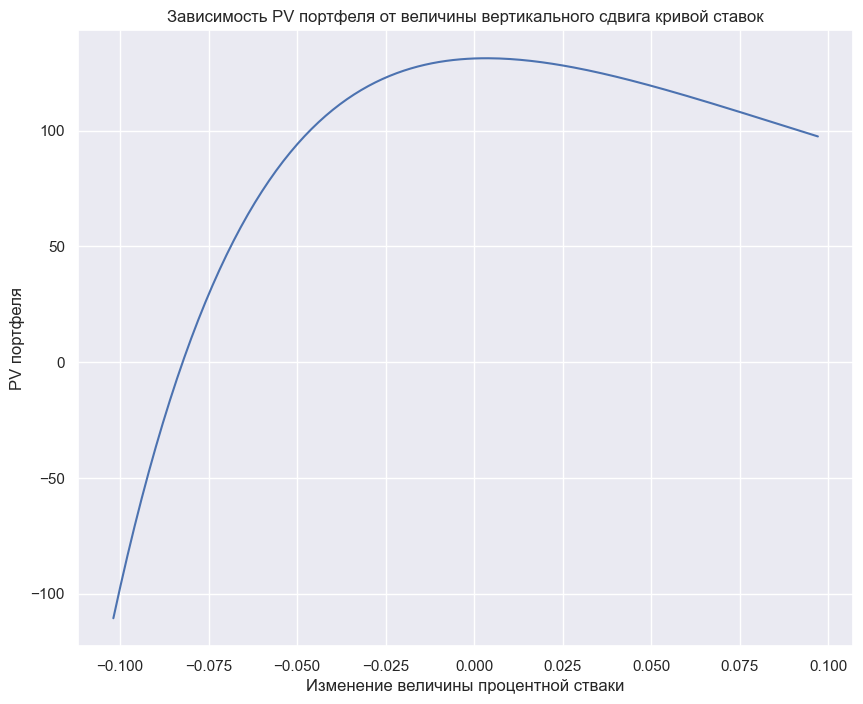

In [92]:
plt.figure(figsize=(10, 8))
plt.title("Зависимость PV портфеля от величины вертикального сдвига кривой ставок")
plt.xlabel("Изменение величины процентной стваки")
plt.ylabel("PV портфеля")
plt.plot(r, pv);
